In [107]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

import yfinance as yf

from warnings import filterwarnings
filterwarnings('ignore')

In [95]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

In [61]:
import gpytorch
import os
import torch

In [20]:
#SPY = SP500
tickers = ['SPY', 'AAL', 'AMZN', 'PFE', 'DB', 'WMT']

In [21]:
sp500 = yf.download(tickers[0], start='2012-01-01', end='2022-10-14')

[*********************100%***********************]  1 of 1 completed


In [22]:
sp500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,127.760002,128.380005,127.430000,127.500000,104.071892,193697900
2012-01-04,127.199997,127.809998,126.709999,127.699997,104.235138,127186500
2012-01-05,127.010002,128.229996,126.430000,128.039993,104.512688,173895000
2012-01-06,128.199997,128.220001,127.290001,127.709999,104.243332,148050000
2012-01-09,128.000000,128.179993,127.410004,128.020004,104.496346,99530200
...,...,...,...,...,...,...
2022-10-07,368.970001,373.290009,360.940002,362.790009,362.790009,107789500
2022-10-10,363.959991,364.209991,357.670013,360.019989,360.019989,76042800
2022-10-11,358.239990,363.029999,355.709991,357.739990,357.739990,92482800


In [23]:
sp500['ret'] = sp500['Adj Close'].pct_change()
sp500.dropna(inplace=True)

In [24]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume,ret
Date,,,,,,,
2012-01-04,127.199997,127.809998,126.709999,127.699997,104.235138,127186500,0.001569
2012-01-05,127.010002,128.229996,126.430000,128.039993,104.512688,173895000,0.002663
2012-01-06,128.199997,128.220001,127.290001,127.709999,104.243332,148050000,-0.002577
2012-01-09,128.000000,128.179993,127.410004,128.020004,104.496346,99530200,0.002427
2012-01-10,129.389999,129.649994,128.949997,129.130005,105.402405,115282000,0.008671


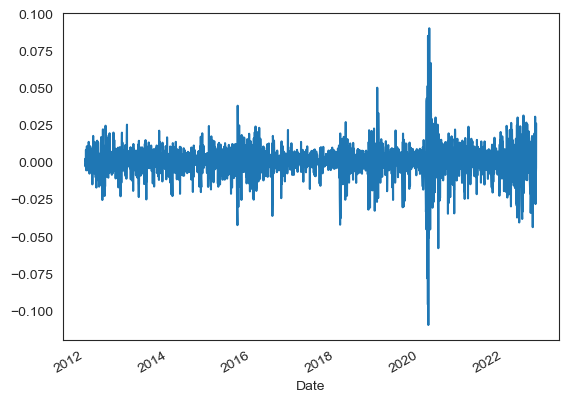

In [25]:
sp500['ret'].plot();

In [ ]:
def generateLag(sp500, lags=3):
    for i in range(lags):
        sp500.loc['lag' + str(i+1)] = sp500['Close'].shift(i+1)
    return sp500

In [ ]:
sp500_lag = generateLag(sp500).dropna()

In [ ]:
sp500_lag.loc[sp500_lag.loc[:, 'ret'] > 0, 'dir'] = 1
sp500_lag.loc[sp500_lag.loc[:, 'ret'] < 0, 'dir'] = -1

In [ ]:
sp500_lag.head()

In [26]:
sp500

,Open,High,Low,Close,Adj Close,Volume,ret
Date,,,,,,,
2012-01-04,127.199997,127.809998,126.709999,127.699997,104.235138,127186500,0.001569
2012-01-05,127.010002,128.229996,126.430000,128.039993,104.512688,173895000,0.002663
2012-01-06,128.199997,128.220001,127.290001,127.709999,104.243332,148050000,-0.002577
2012-01-09,128.000000,128.179993,127.410004,128.020004,104.496346,99530200,0.002427
2012-01-10,129.389999,129.649994,128.949997,129.130005,105.402405,115282000,0.008671
...,...,...,...,...,...,...,...
2022-10-07,368.970001,373.290009,360.940002,362.790009,362.790009,107789500,-0.027894
2022-10-10,363.959991,364.209991,357.670013,360.019989,360.019989,76042800,-0.007635
2022-10-11,358.239990,363.029999,355.709991,357.739990,357.739990,92482800,-0.006333


In [31]:
train = sp500_lag.iloc[:int(sp500_lag.shape[0]*0.8)]
test = sp500_lag.iloc[int(sp500_lag.shape[0]*0.8):]

In [32]:
train.shape, test.shape

((2170, 7), (543, 7))

<AxesSubplot:xlabel='Date'>

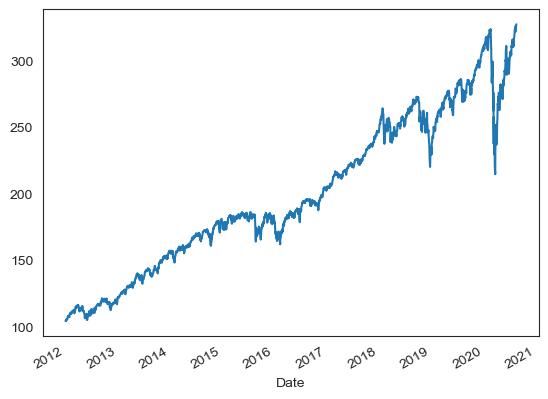

In [49]:
train['Adj Close'].plot()

## GP Regression

In [51]:
long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
mix_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)

In [33]:
def plot_gp(x_pred, y_pred, sigmas, x_train, y_train, true_y=None, samples=None):
    """
    Function that plots the GP mean & std on top of given points.
    x_pred: points for prediction
    y_pred: means
    sigmas: std
    x, y: given data
    true_y: 
    samples: 2D numpy array with shape (# of points, # of samples)
    """
    if samples is not None:
        plt.plot(all_x.reshape(-1, 1), samples)
    
    plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0, 
                 ecolor=(0.85, 0.85, 0.85), fmt = "r-", 
                 label="pred mean")
    plt.plot(x_train, y_train, "ko", label="training set")
    if true_y is not None:
        plt.plot(x_pred, true_y, "b-", label="truth function")
    plt.legend()

In [198]:
# train_cols = ['lag1', 'lag2', 'lag3']
train_cols = ['Open', 'High', 'Low', 'lag1', 'lag2', 'lag3']

In [45]:
def convertTime(series):
    time = series.year  + (series.month * 30 + series.day) / 365
    return np.array(time)

In [46]:
X = convertTime(pd.to_datetime(train.index))

In [105]:
train.iloc

,Open,High,Low,Close,Adj Close,Volume,ret
Date,,,,,,,
2012-01-04,127.199997,127.809998,126.709999,127.699997,104.235161,127186500.0,0.001569
2012-01-05,127.010002,128.229996,126.430000,128.039993,104.512650,173895000.0,0.002662
2012-01-06,128.199997,128.220001,127.290001,127.709999,104.243317,148050000.0,-0.002577
2012-01-09,128.000000,128.179993,127.410004,128.020004,104.496376,99530200.0,0.002428
2012-01-10,129.389999,129.649994,128.949997,129.130005,105.402367,115282000.0,0.008670
...,...,...,...,...,...,...,...
2020-08-12,335.440002,338.279999,335.410004,337.440002,326.485565,53774400.0,0.013942
2020-08-13,336.609985,338.250000,335.829987,336.829987,325.895355,41816100.0,-0.001808
2020-08-14,336.410004,337.420013,335.619995,336.839996,325.904999,47260400.0,0.000030


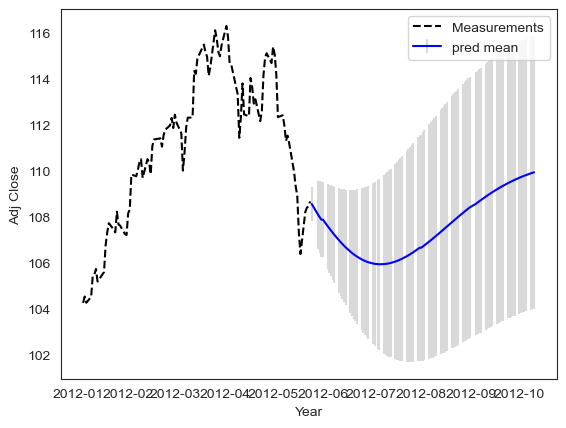

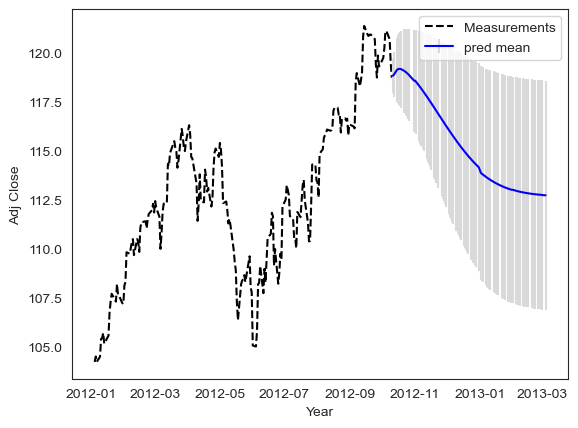

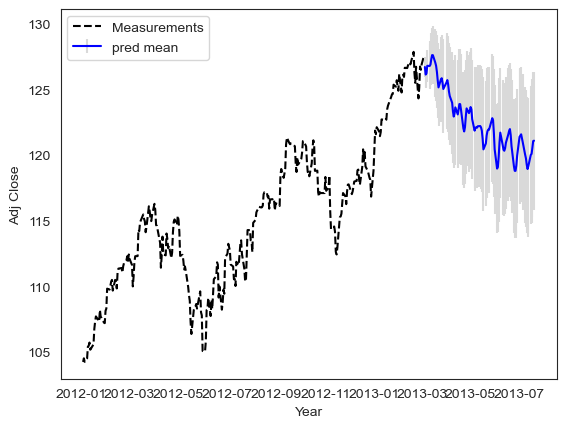

MAPE: 0.08897406341312923
MSE: 182.00590364303824
MSLE: 0.01074556509619629


In [113]:
kernel = mix_kernel
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X):
    split_train, split_test = train.iloc[train_index], train.iloc[test_index]

    X = convertTime(pd.to_datetime(split_train.index)).reshape(-1, 1)
    y = split_train['Adj Close'].to_numpy().reshape(-1, 1)
    y_mean = y.mean()
    X_test = convertTime(pd.to_datetime(split_test.index)).reshape(-1, 1)
    y_test = split_test['Adj Close'].to_numpy().reshape(-1, 1)
    
    mapes = []
    mses = []
    msles = []

    gaussian_process = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
    gaussian_process.fit(X, y - y_mean)
    mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
    mean_y_pred += y_mean
    plt.plot(split_train.index, split_train['Adj Close'], color="black", linestyle="dashed", label="Measurements")
    plt.errorbar(split_test.index, mean_y_pred.reshape(1, -1)[0], yerr=std_y_pred, capsize=0, 
                 ecolor=(0.85, 0.85, 0.85), fmt = "b-", 
                 label="pred mean")
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Adj Close")
    plt.show();

    # print the kernel with fitted parameters
#     print(gaussian_process.kernel_)
#     plt.figure()
#     plt.imshow(gaussian_process.kernel_(X))
#     plt.colorbar()
#     plt.title('kernel post-fitting')

    mapes.append(mean_absolute_percentage_error(y_test, mean_y_pred))
    mses.append(mean_squared_error(y_test, mean_y_pred))
    msles.append(mean_squared_log_error(y_test, mean_y_pred))

# loss function
print("MAPE:", np.mean(mapes))
print("MSE:", np.mean(mses))
print("MSLE:", np.mean(msles))


In [ ]:
mean_y_train, std_y_train = gaussian_process.predict(X, return_std=True)
mean_y_train += y_mean

plt.plot(sp500.index, sp500['Adj Close'], color="black", linestyle="dashed", label="Measurements")

plt.errorbar(train.index, mean_y_train.reshape(1, -1)[0], yerr=std_y_train, capsize=0, 
             ecolor=(0.85, 0.85, 0.85), fmt = "b-", 
             label="pred mean")
plt.errorbar(test.index, mean_y_pred.reshape(1, -1)[0], yerr=std_y_pred, capsize=0, 
                 ecolor=(0.85, 0.85, 0.85), fmt = "b-", 
                 label="pred mean")

In [62]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

train_x = torch.from_numpy(X.reshape(1, -1)[0])
train_y = torch.from_numpy(y.reshape(1, -1)[0])
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(train_x, train_y, likelihood)

In [63]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 30461.722
Iter 2/100 - Loss: 28337.342
Iter 3/100 - Loss: 26417.838
Iter 4/100 - Loss: 24644.274
Iter 5/100 - Loss: 23062.709
Iter 6/100 - Loss: 21630.811
Iter 7/100 - Loss: 20331.864
Iter 8/100 - Loss: 19157.968
Iter 9/100 - Loss: 18088.720
Iter 10/100 - Loss: 17121.861
Iter 11/100 - Loss: 16244.520
Iter 12/100 - Loss: 15445.369
Iter 13/100 - Loss: 14716.168
Iter 14/100 - Loss: 14056.760
Iter 15/100 - Loss: 13454.302
Iter 16/100 - Loss: 12902.212
Iter 17/100 - Loss: 12401.759
Iter 18/100 - Loss: 11942.655
Iter 19/100 - Loss: 11517.489
Iter 20/100 - Loss: 11130.044
Iter 21/100 - Loss: 10769.839
Iter 22/100 - Loss: 10435.064
Iter 23/100 - Loss: 10128.712
Iter 24/100 - Loss: 9841.336
Iter 25/100 - Loss: 9574.835
Iter 26/100 - Loss: 9330.522
Iter 27/100 - Loss: 9100.936
Iter 28/100 - Loss: 8887.282
Iter 29/100 - Loss: 8686.097
Iter 30/100 - Loss: 8495.225
Iter 31/100 - Loss: 8324.500
Iter 32/100 - Loss: 8158.287
Iter 33/100 - Loss: 8002.840
Iter 34/100 - Loss: 7856.698


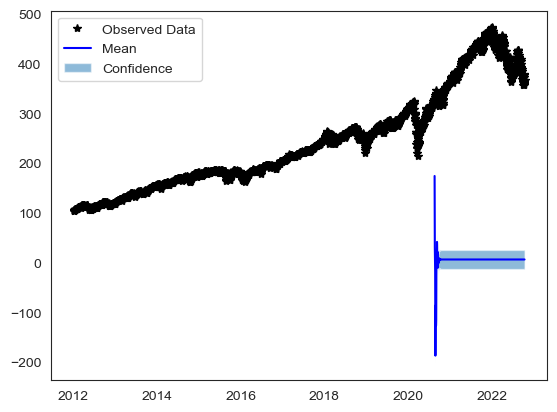

In [91]:
# Test points every 0.1 between 0 and 5
test_x = torch.from_numpy(X_test.reshape(1, -1)[0]).float()

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058

# Make predictions
observed_pred = likelihood(model(test_x))
# Initialize plot
f, ax = plt.subplots(1, 1)

# Get upper and lower confidence bounds
lower, upper = observed_pred.confidence_region()
# Plot training data as black stars
ax.plot(sp500.index, sp500['Adj Close'], 'k*')
# Plot predictive means as blue line
ax.plot(test.index, observed_pred.mean.detach().numpy(), 'b')
# Shade between the lower and upper confidence bounds
ax.fill_between(test.index, lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])